In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import polars as pl
import seaborn as sns
from jax import random

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
data_path = "https://raw.githubusercontent.com/felipeangelimvieira/prophetverse/main/docs/examples/tourism.csv"

raw_data_df = pl.read_csv(data_path, try_parse_dates=True)

data_df = raw_data_df.select(pl.all().name.to_lowercase())

data_df.head()

,quarter,region,state,purpose,trips
i64,date,str,str,str,f64
1,1998-01-01,"""Adelaide""","""South Australia""","""Business""",135.07769
2,1998-04-01,"""Adelaide""","""South Australia""","""Business""",109.987316
3,1998-07-01,"""Adelaide""","""South Australia""","""Business""",166.034687
4,1998-10-01,"""Adelaide""","""South Australia""","""Business""",127.160464
5,1999-01-01,"""Adelaide""","""South Australia""","""Business""",137.448533


In [3]:
data_df.group_by("state").agg(pl.col("region").n_unique().alias("n_regions"))

state,n_regions
str,u32
"""Victoria""",21
"""ACT""",1
"""New South Wales""",13
"""South Australia""",12
"""Northern Territory""",13
"""Western Australia""",5
"""Queensland""",12


In [4]:
assert (
    data_df["region"].n_unique()
    == data_df.group_by("state")
    .agg(pl.col("region").n_unique().alias("n_regions"))["n_regions"]
    .sum()
)

In [5]:
data_df["purpose"].unique()

purpose
str
"""Holiday"""
"""Business"""
"""Visiting"""
"""Other"""


In [6]:
assert (
    data_df["purpose"].unique().shape[0]
    == data_df.group_by("region")
    .agg(pl.col("purpose").n_unique().alias("n_purposes"))["n_purposes"]
    .unique()
    .item()
)

In [7]:
data_df = data_df.with_columns(
    unique_id=pl.concat_str(
        [pl.col("state"), pl.col("region"), pl.col("purpose")], separator="::"
    )
)

data_df["unique_id"].n_unique()

308

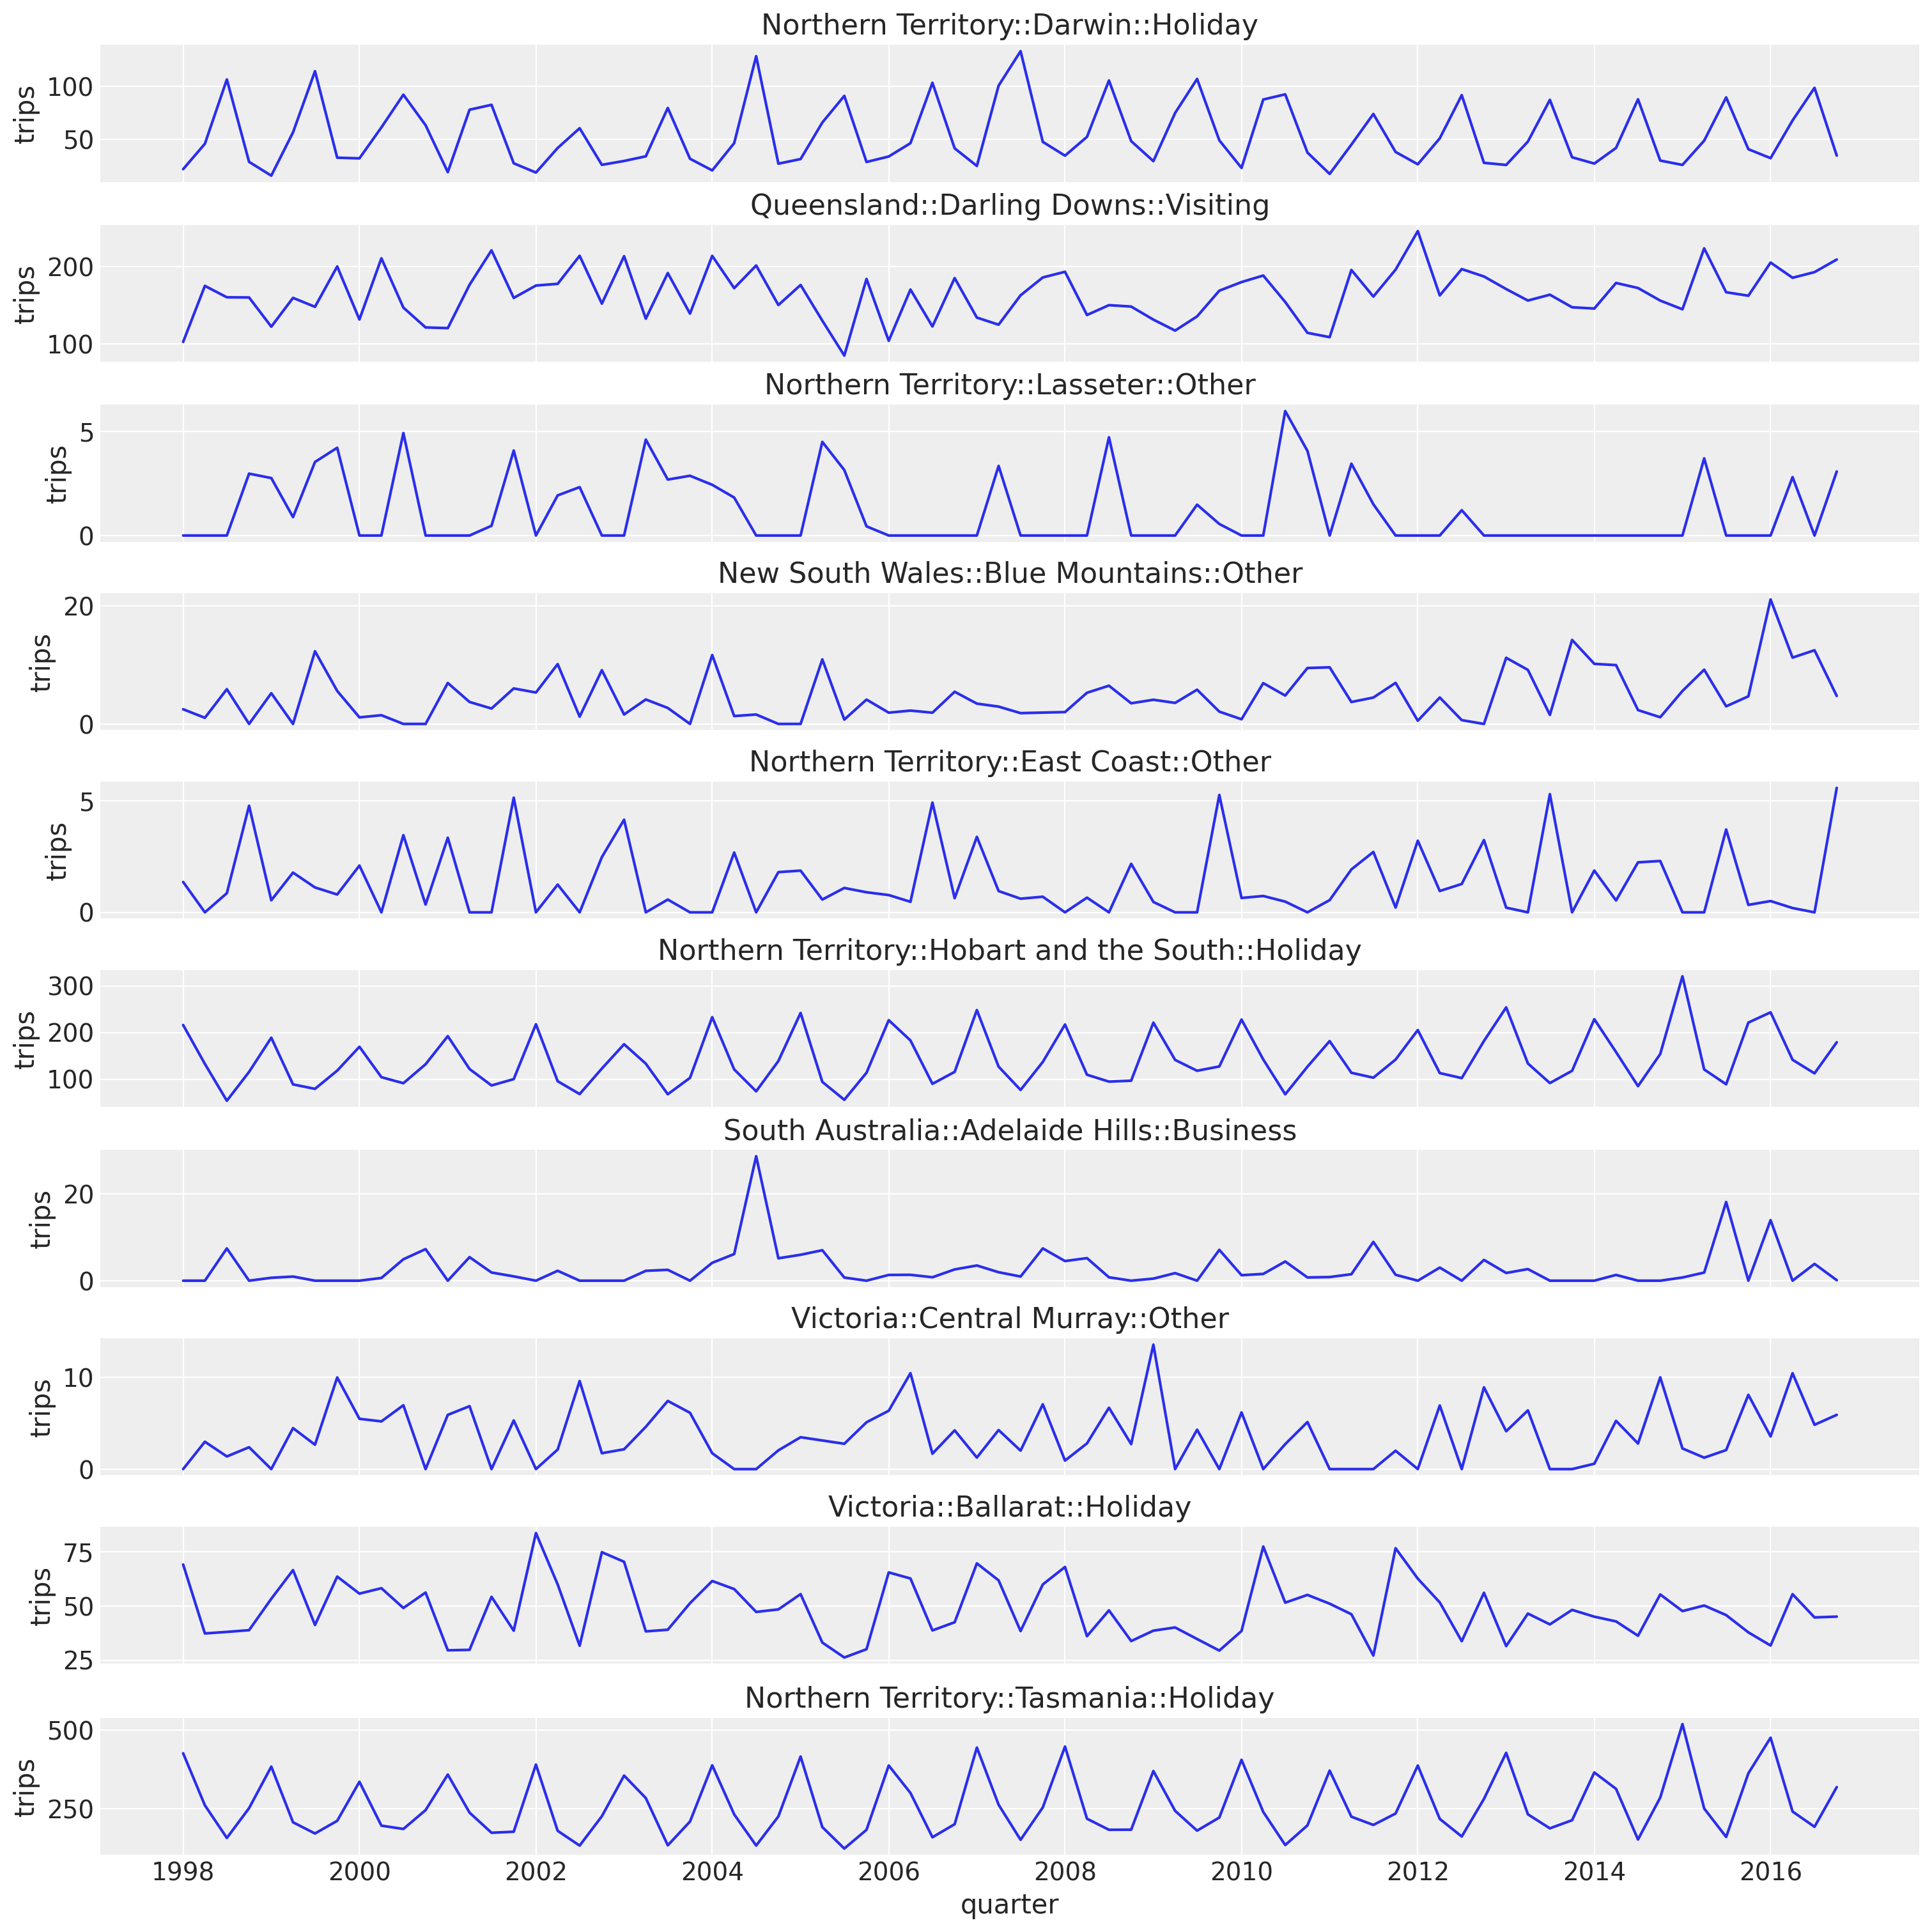

In [8]:
n_series = 10

unique_ids = data_df.select("unique_id").sample(
    n=n_series, with_replacement=False, seed=42
)

fig, axes = plt.subplots(
    nrows=n_series,
    ncols=1,
    figsize=(15, 15),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, unique_id in enumerate(unique_ids["unique_id"]):
    ax = axes[i]
    sns.lineplot(
        data=data_df.filter(pl.col("unique_id") == unique_id),
        x="quarter",
        y="trips",
        ax=ax,
    )
    ax.set(title=unique_id)

In [11]:
pivot_data_df = data_df.pivot(index="quarter", columns="unique_id", values="trips")  # noqa: PD010

In [24]:
n_test = 12

pivot_data_train_df = pivot_data_df[:-n_test, :]

pivot_data_test_df = pivot_data_df[-n_test:, :]

assert (
    pivot_data_train_df.shape[0] + pivot_data_test_df.shape[0] == pivot_data_df.shape[0]
)

In [34]:
date_train = pivot_data_train_df["quarter"].to_numpy()
y_train = jnp.array(pivot_data_train_df.drop("quarter"))

date_test = pivot_data_test_df["quarter"].to_numpy()
y_test = jnp.array(pivot_data_test_df.drop("quarter"))